In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import json
import numpy as np
from src import dataloader
from models import transformers, engine, configs
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


In [3]:
from models import models 
import ml_collections

### Data Generation

In [4]:
dataset = dataloader.input_dataframe_generater(img_path    = None, 
                                    target_path            = None, 
                                    first_date_string      = configs.data_config_dict['start_date'], 
                                    last_date_string       = configs.data_config_dict['finish_date'], 
                                    target_binarizing_thre = configs.data_config_dict['vis_threshold']).dataframe_generation()
dataset.head(5)

,date_time,round_time,date_cycletime,date,cycletime,year,month,day,nam_nc_files_path,mur_nc_files_path,vis,vis_class,vis_category
0,20200102 05:55:00,20200102 06:00:00,20200102_0000,20200102,0000,2020,01,02,/data1/fog-data/fog-maps/2020/2020002/maps_202...,/data1/fog-data/fog-maps/2020/2020002/murs_202...,10.0,0,non_fog
1,20200102 11:55:00,20200102 12:00:00,20200102_0600,20200102,0600,2020,01,02,/data1/fog-data/fog-maps/2020/2020002/maps_202...,/data1/fog-data/fog-maps/2020/2020002/murs_202...,10.0,0,non_fog
2,20200102 17:55:00,20200102 18:00:00,20200102_1200,20200102,1200,2020,01,02,/data1/fog-data/fog-maps/2020/2020002/maps_202...,/data1/fog-data/fog-maps/2020/2020002/murs_202...,10.0,0,non_fog
3,20200102 23:55:00,20200103 00:00:00,20200102_1800,20200102,1800,2020,01,02,/data1/fog-data/fog-maps/2020/2020002/maps_202...,/data1/fog-data/fog-maps/2020/2020002/murs_202...,10.0,0,non_fog
4,20200103 05:55:00,20200103 06:00:00,20200103_0000,20200103,0000,2020,01,03,/data1/fog-data/fog-maps/2020/2020003/maps_202...,/data1/fog-data/fog-maps/2020/2020003/murs_202...,10.0,0,non_fog


In [5]:
norm_mean_std_dict = dataloader.return_train_variable_mean_std(dataset, 
                                    predictor_names = configs.data_config_dict['predictor_names'], 
                                    lead_time_pred = configs.data_config_dict['lead_time_pred']).return_mean_std_dict()
norm_mean_std_dict

{'TMP_2maboveground': [292.5612836206475, 2.1498436007936226],
 'TMP_975mb': [290.37403706489846, 2.7407228726066277],
 'TMP_950mb': [289.15713553503156, 3.141220236912526],
 'TMP_925mb': [288.1659073140472, 3.239149826408609],
 'TMP_900mb': [287.40729167240744, 3.2123160047004853],
 'TMP_875mb': [286.68297892579665, 3.195402088405803],
 'TMP_850mb': [285.89965564442366, 3.2542470417605798],
 'TMP_825mb': [285.04632731784994, 3.30164845340873],
 'TMP_800mb': [284.19832330798874, 3.210668971237745],
 'TMP_775mb': [283.3198418529847, 3.0027520356236117],
 'TMP_750mb': [282.2553576718156, 2.8131714877920375],
 'TMP_725mb': [280.9241548384038, 2.6403689976821743],
 'TMP_700mb': [279.34402514922505, 2.434866837391358],
 'UGRD_10maboveground': [-1.739038119998969, 2.9359049857006103],
 'VGRD_10maboveground': [1.9914165990995443, 4.662295341850214],
 'FRICV_surface': [0.26591284967212386, 0.11244108087384636],
 'UGRD_975mb': [-1.6871929619611583, 4.062717322276822],
 'VGRD_975mb': [4.65430581

In [6]:
train_dataset = dataloader.DataAdopter(dataset, 
                            map_structure         = configs.data_config_dict['data_straucture'], 
                            predictor_names       = configs.data_config_dict['predictor_names'], 
                            lead_time_pred        = configs.data_config_dict['lead_time_pred'], 
                            mean_std_dict         = norm_mean_std_dict,
                            point_geolocation_dic = configs.data_config_dict['points_coords'])
train_dataset[0]

{'input': tensor([[[[-1.4015e+00, -3.0329e-01,  1.6972e-01,  ..., -1.4051e+00,
             2.6950e+01,  2.8355e+01],
           [-1.4481e+00, -8.4363e-02,  1.6972e-01,  ..., -1.4079e+00,
             2.7439e+01,  2.8847e+01],
           [-1.4015e+00,  1.7105e-01,  1.6972e-01,  ..., -1.3614e+00,
             2.5388e+01,  2.6749e+01],
           ...,
           [ 1.7615e+00,  1.5940e+00,  1.2839e+00,  ...,  5.1298e-01,
            -1.1557e+01, -1.2070e+01],
           [ 1.7615e+00,  1.5940e+00,  1.2839e+00,  ...,  5.3482e-01,
            -1.2071e+01, -1.2606e+01],
           [ 1.8080e+00,  1.5940e+00,  1.3158e+00,  ...,  5.8133e-01,
            -1.1746e+01, -1.2327e+01]],
 
          [[-1.4481e+00, -3.7625e-01,  1.3789e-01,  ..., -1.3861e+00,
             2.7976e+01,  2.9362e+01],
           [-1.4946e+00, -1.9382e-01,  1.6972e-01,  ..., -1.4107e+00,
             2.8465e+01,  2.9876e+01],
           [-1.5411e+00,  2.5093e-02,  2.0156e-01,  ..., -1.4354e+00,
             2.8380e+01,  2.98

In [7]:
train_dataset[0]['input'].shape

torch.Size([4, 32, 32, 97])

In [8]:
sample = torch.unsqueeze(train_dataset[0]['input'], axis = 0)
sample   = sample.permute(0, 4, 2, 3, 1)
sample.shape

torch.Size([1, 97, 32, 32, 4])

### Check different tensorized

#### 2D Patch

In [43]:
def SparkMET_4D_config():
    """Returns the ViT configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (8, 8)})
    config.embd_size = 24832
    config.in_channels = 388
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 512
    config.transformer.num_heads = 8
    config.transformer.num_layers = 4
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.3
    config.classifier = 'token'
    config.representation_size = None
    return config


In [44]:
Embd = models.Embeddings_2D_Patch(SparkMET_4D_config(), img_size = 32)
embeding_maps = Embd(sample)
embeding_maps.shape

torch.Size([1, 17, 24832])

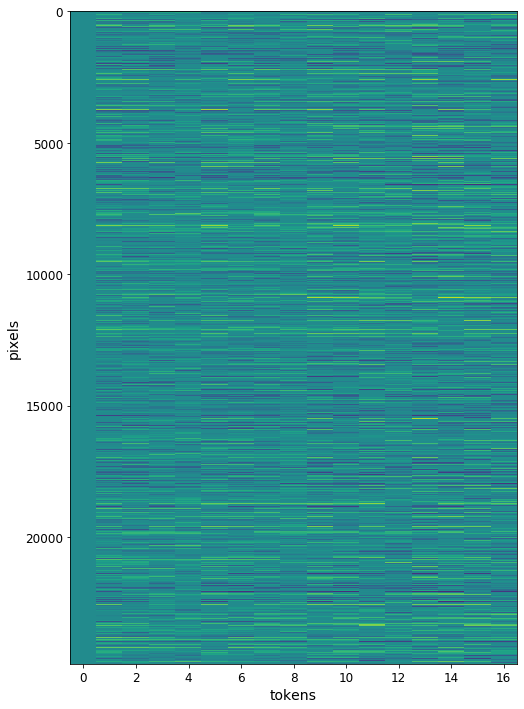

In [47]:
tokens = embeding_maps.permute(0, 2, 1)
fig, axs = plt.subplots(1, 1, figsize = (12, 12))
axs.imshow(tokens[0, :, :].detach().numpy(), aspect = 0.001)
axs.set_xlabel('tokens')
axs.set_ylabel('pixels')
None

#### Embeddings_2D_SpatioTemporal_Patch

In [53]:
def SparkMET_4D_config():
    """Returns the ViT configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (8, 8)})
    config.embd_size = 6208
    config.in_channels = 97
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 512
    config.transformer.num_heads = 8
    config.transformer.num_layers = 4
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.3
    config.classifier = 'token'
    config.representation_size = None
    return config


In [59]:
Embd_ST       = models.Embeddings_2D_SpatioTemporal_Patch(SparkMET_4D_config(), img_size = 32)
embeding_maps2 = Embd_ST(sample)
embeding_maps2.shape

torch.Size([1, 65, 6208])

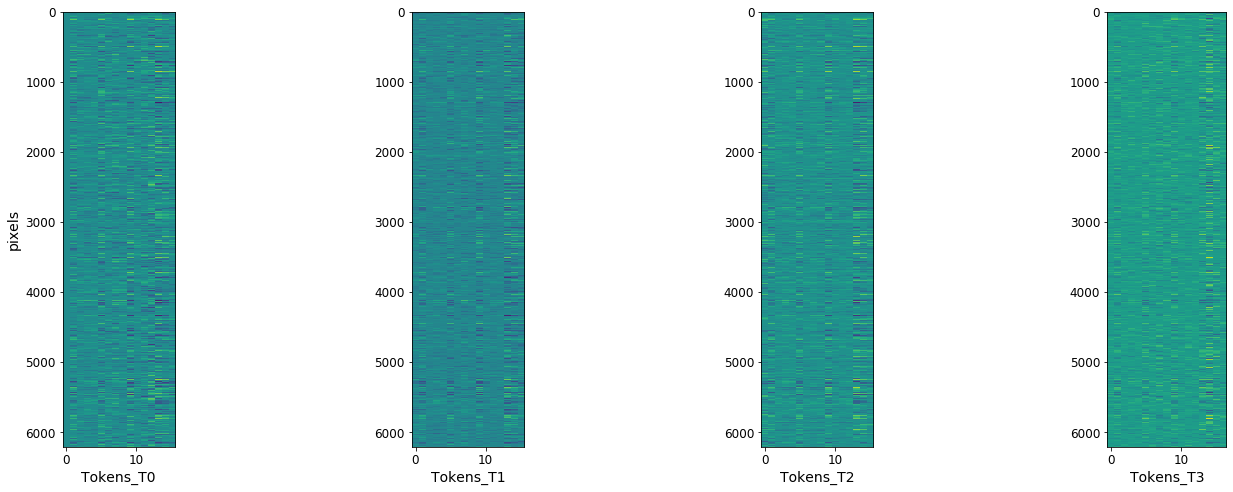

In [67]:
tokens = embeding_maps2.permute(0, 2, 1).detach().numpy()
img_t0 = tokens[0, :, :16]
img_t1 = tokens[0, :, 16:32]
img_t2 = tokens[0, :, 32:48]
img_t3 = tokens[0, :, 48:]
fig, axs = plt.subplots(1, 4, figsize = (24, 8))
axs[0].imshow(img_t0, aspect = 0.01)
axs[0].set_xlabel('Tokens_T0')
axs[0].set_ylabel('pixels')

axs[1].imshow(img_t1, aspect = 0.01)
axs[1].set_xlabel('Tokens_T1')

axs[2].imshow(img_t2, aspect = 0.01)
axs[2].set_xlabel('Tokens_T2')

axs[3].imshow(img_t3, aspect = 0.01)
axs[3].set_xlabel('Tokens_T3')

None

#### Embeddings_2D_Channel

In [68]:
def SparkMET_4D_config():
    """Returns the ViT configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (32, 32)})
    config.embd_size = 1024
    config.in_channels = 1
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 512
    config.transformer.num_heads = 8
    config.transformer.num_layers = 4
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.3
    config.classifier = 'token'
    config.representation_size = None
    return config


In [72]:
Embd_C      = models.Embeddings_2D_Channel(SparkMET_4D_config(), img_size = 32)
embeding_maps3 = Embd_C(sample)
embeding_maps3.shape

torch.Size([1, 389, 1024])

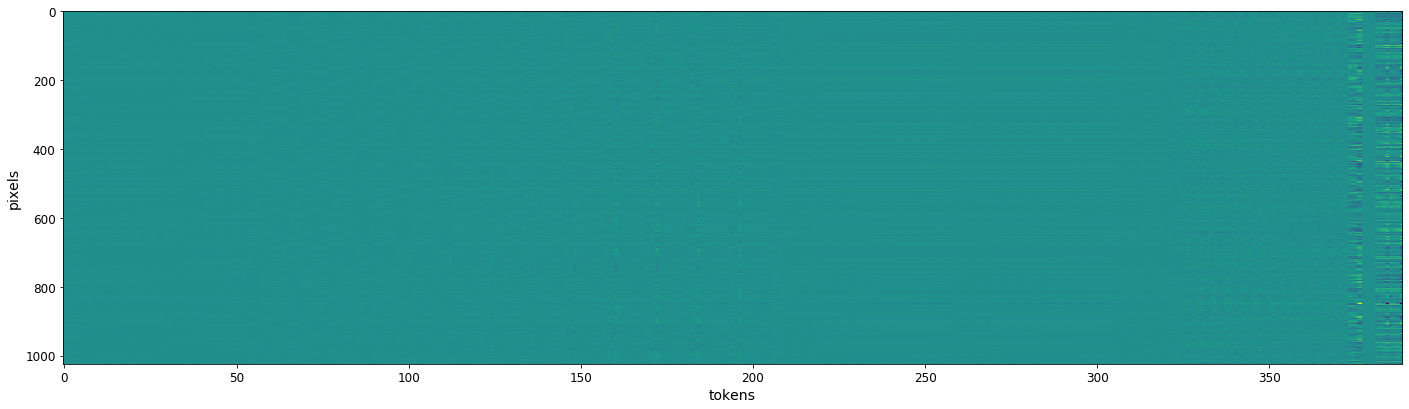

In [74]:
tokens = embeding_maps3.permute(0, 2, 1)
fig, axs = plt.subplots(1, 1, figsize = (24, 12))
axs.imshow(tokens[0, :, :].detach().numpy(), aspect = 0.1)
axs.set_xlabel('tokens')
axs.set_ylabel('pixels')
None

### check Factorized Encoder 

In [19]:
def SparkMET_4D_config():
    """Returns the ViT configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (8, 8)})
    config.embd_size = 6208
    config.in_channels = 97
    config.in_times    = 4
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 512
    config.transformer.num_heads = 8
    config.transformer.num_layers = 4
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.3
    config.transformer.Emb_M = 'Emb_2D_Patch'
    config.classifier = 'token'
    config.representation_size = None
    return config

In [36]:
Embd_C      = models.Factorized_VisionTransformer(SparkMET_4D_config(), img_size = 32, num_classes = 2, zero_head = False, vis = True)
Attns, Preds = Embd_C(sample)